# Supplementary code to arXiv:2402.13999


Suppose we have a feature map $\phi\colon\mathbf R^d \to\mathbf R^p$ on which we can perform ridge regression with $n$ samples $(x_i,y_i)$, $i=1,\ldots,n$. By the representer theorem we know that

$$
f(x) = \sum_{i=1}^n\alpha_i \phi(x)^\top\phi(x_i),
$$

so that minimizing

$$
\begin{split}
\sum_j (y_j - f(x_j))^2 + \lambda \sum_j (\phi(x_j)^\top \alpha)^2 &= \sum_j (y_j - \sum_{i=1}^n \phi(x_j)^\top\phi(x_i)\alpha_i)^2 + \lambda \sum_j (\phi(x_j)^\top \alpha)^2\\
& = \lVert y - \Phi^\top\Phi \alpha\rVert^2 + \lambda \lVert\Phi\alpha\rVert^2,
\end{split}
$$

with $\Phi:=(\phi(x_1),\cdots,\phi(x_n))\in\mathbf R^{p\times n}$, with respect to $\alpha$ yields

$$
\hat\alpha := (\Phi^\top\Phi + \lambda I)^{-1}y, \quad \hat f(x) = \phi(x)^\top\Phi (\Phi^\top\Phi + \lambda I)^{-1}y= \phi(x)^\top (\Phi \Phi^\top + \lambda I)^{-1}\Phi y.
$$

Our theorem from https://arxiv.org/abs/2402.13999 gives a theoretical prediction for the generalization error

$$
    \mathcal E_\mathrm{gen} := \mathbf E_{x',y'} (y' - \hat f(x'))^2 = \mathbf E_{x',y'} (y' - \phi(x')^\top\hat \alpha)^2 = \sigma^2 + \hat\alpha^\top\Omega\hat\alpha - 2 \psi^\top\hat \alpha,
$$

where

$$
    \mathbf E \phi(x)\phi(x)^\top = \Omega, \qquad \mathbf E \phi(x) = 0, \qquad \mathbf E \phi(x)y = \psi,\qquad \mathbf E y^2 = \sigma^2,
$$

in terms of the formula

$$
    \mathcal E_\mathrm{gen}^\mathrm{rmt}:=\frac{ \sigma^2 -  n\lambda m\psi^\top (M+\lambda M^2)\psi }{1-n(m\lambda)^2\operatorname{Tr} \Omega M\Omega M}.
$$

Here $M,m$ are defined by

$$
    \frac{1}{m(\lambda)} = \lambda + \operatorname{Tr} \Omega (1 + n m(\lambda)\Omega )^{-1}, \quad M(\lambda) := (\lambda + \lambda n m(\lambda)\Omega )^{-1},
$$


# Imports


In [2]:
%%script false --no-raise-error       
# Comment out the previous line to install the required packages (typst icecream pyobsplot) on Linux platforms (e.g. Colab). Otherwise, just install the required packages manually.
! pip install typst icecream pyobsplot -q
! apt-get install -y ca-certificates curl gnupg
! mkdir -p /etc/apt/keyrings
! curl -fsSL https://deb.nodesource.com/gpgkey/nodesource-repo.gpg.key | sudo gpg --dearmor -o /etc/apt/keyrings/nodesource.gpg
! echo "deb [signed-by=/etc/apt/keyrings/nodesource.gpg] https://deb.nodesource.com/node_18.x nodistro main" | sudo tee /etc/apt/sources.list.d/nodesource.list
! apt-get update
! apt-get install -y nodejs
! npm install -g npm
! npm install pyobsplot
! rm -rf "feature-ridge-regression"
! git clone https://github.com/wirhabenzeit/feature-ridge-regression.git
%cd feature-ridge-regression

In [3]:
import numpy as np
import polars as pl
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tqdm import tqdm
from tqdm.keras import TqdmCallback
from obsplot import Obsplot, js, Plot
from regression import FeatureRidgeRegression

obsplot = Obsplot(font="Liberation Sans")
tf.get_logger().setLevel("ERROR")

# Auxiliary functions


In [4]:
def rational_log_space(max_val, denom=10, num_val=100):
    """
    Create a logarithmic space with rational numbers.
    :param max_val: Maximum value of the space.
    :param denom: Denominator of the rational numbers.
    :param num_val: Number of values in the space.
    :return: The logarithmic space.
    """
    return (np.unique(np.geomspace(1, max_val * denom + 1, num_val, dtype=int)) - 1) / denom


def rational_pow_space(max_val, denom=10, power=2, num_val=100):
    """
    Create a power space with rational numbers.
    :param max_val: Maximum value of the space.
    :param denom: Denominator of the rational numbers.
    :param power: Power of the space.
    :param num_val: Number of values in the space.
    :return: The power space.
    """
    return np.unique(np.round(np.linspace(0, (max_val * denom) ** (1 / power), num_val) ** power)) / denom


def choose(arr, num):
    return [list(arr)[i] for i in np.round(np.linspace(0, len(arr) - 1, num)).astype(int)]

In [5]:
def normalize(images):
    mz = images - np.mean(images, axis=0)
    return mz / mz.std()


def random_split(prop, images, labels):
    rng = np.random.default_rng()
    choice = rng.choice(list(prop.keys()), p=list(prop.values()), size=len(labels))
    return {k: (images[choice == k], labels[choice == k]) for k in prop.keys()}

In [6]:
class SaveFeatures(keras.callbacks.Callback):
    def __init__(self, save_callback):
        super().__init__()
        self.log = []
        self.n_epochs = 0
        self.n_steps = 0
        self.save_callback = save_callback

    def save(self):
        if res := self.save_callback(self.model, n_epoch=self.n_epochs, n_step=self.n_steps):
            self.log.append(res)

    def on_epoch_begin(self, epoch, logs=None):
        self.n_epochs = epoch
        self.n_steps = 0

    def on_train_batch_begin(self, batch, logs=None):
        self.save()
        self.n_steps += 1

    def on_train_end(self, logs=None):
        self.n_epochs += 1
        self.n_steps = 0
        self.save()

In [7]:
def train_model(model, train_data, test_data, n_epochs=10, batch_size=32, n_callbacks=10, callbacks=None, verbose=0):
    num_steps = np.ceil(len(train_data[1]) / batch_size)
    model.compile(optimizer="adam", loss="mean_squared_error")
    callbacks = callbacks or dict()
    callback_steps = rational_log_space(n_epochs, denom=num_steps, num_val=n_callbacks)

    def save_callback(keras_model, n_epoch=0, n_step=0):
        if n_epoch + n_step / num_steps not in callback_steps:
            return
        acc = keras_model.evaluate(*test_data, verbose=verbose)
        return {"loss": acc, "epoch": n_epoch, "step": n_step, "epoch+step": n_epoch + n_step / num_steps, "type": "NN"} | {
            name: fun(keras_model) for name, fun in callbacks.items()
        }

    regression_objs = SaveFeatures(save_callback)
    history = keras.callbacks.History()

    model.fit(
        *train_data,
        epochs=n_epochs,
        validation_data=test_data,
        batch_size=batch_size,
        verbose=verbose,
        shuffle=True,
        callbacks=[regression_objs, history, TqdmCallback(verbose=1, tqdm_class=tqdm)],
    )

    obsplot(
        {
            "marks": [
                Plot.lineY(
                    pl.DataFrame(history.history).with_columns(pl.Series("epoch", range(n_epochs))).melt(id_vars="epoch"),
                    dict(x="epoch", y="value", stroke=js("d=>d.variable=='loss'?'Train':'Test'")),
                )
            ],
            "title": "Training History",
            "color": {"legend": True, "type": "categorical"},
            "y": {"type": "log", "label": "Loss"},
            "x": {"label": "Epoch"},
            "grid": True,
        },
    )

    return regression_objs.log

In [8]:
def regression_from_model(model, data_dict, empirical=True):
    fun = FeatureRidgeRegression.empirical if empirical else FeatureRidgeRegression.linearized
    return fun(
        model,
        train_data=data_dict["train_reg"],
        test_data=data_dict["test"],
        emp_avg_data=data_dict["emp_cov"],
    )

In [9]:
def df_from_regressions(regression_objs, dictionary):
    frames = []
    for elmnt in regression_objs:
        frame = None
        for key, val in dictionary.items():
            new_frame = elmnt[key].learningCurve(**val)
            new_frame = new_frame.rename({name: f"{name}_{key}" for name in ["genErrRMT", "genErrEmp"] if name in new_frame.columns})
            frame = frame.join(new_frame, on=("n", "lamb")) if frame is not None else new_frame
        frames.append(frame.with_columns([pl.lit(val).alias(key) for key, val in elmnt.items() if isinstance(val, (float, int, str))]))
    return pl.concat(frames, how="diagonal_relaxed")

# Real Data


## Importing the data


In [10]:
def filter_imgs(images, labels, class_names, class_map):
    filtered_idx = [i for i, label in enumerate(labels) if class_names[label] in class_map]
    return images[filtered_idx], np.array([class_map[class_names[label]] for label in labels[filtered_idx]])


def get_data(
    name="fashion-MNIST",
    class_map=None,
):
    if class_map is None:
        class_map = {"Shirt": -1, "T-shirt/top": -1, "Pullover": 1, "Coat": 1}
    if name == "fashion-MNIST":
        fashion_mnist = keras.datasets.fashion_mnist
        (
            (train_images, train_labels),
            (test_images, test_labels),
        ) = fashion_mnist.load_data()
        images = np.concatenate([train_images, test_images])
        labels = np.concatenate([train_labels, test_labels])
        class_names = [
            "T-shirt/top",
            "Trouser",
            "Pullover",
            "Dress",
            "Coat",
            "Sandal",
            "Shirt",
            "Sneaker",
            "Bag",
            "Ankle boot",
        ]
        return filter_imgs(images, labels, class_names, class_map)
    if name == "MNIST":
        mnist = keras.datasets.mnist
        (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
        images = np.concatenate([train_images, test_images])
        labels = np.concatenate([train_labels, test_labels])
        class_names = list(range(10))
        return filter_imgs(images, labels, class_names, class_map)
    raise ValueError("Unsupported Dataset")

In [11]:
f_images, f_labels = get_data(name="MNIST", class_map={i: (1 if i % 2 == 0 else -1) for i in range(10)})
f_images = normalize(f_images)
data = random_split({"test": 0.1, "train_reg": 0.25, "train_w": 0.25, "emp_cov": 0.4}, f_images, f_labels)

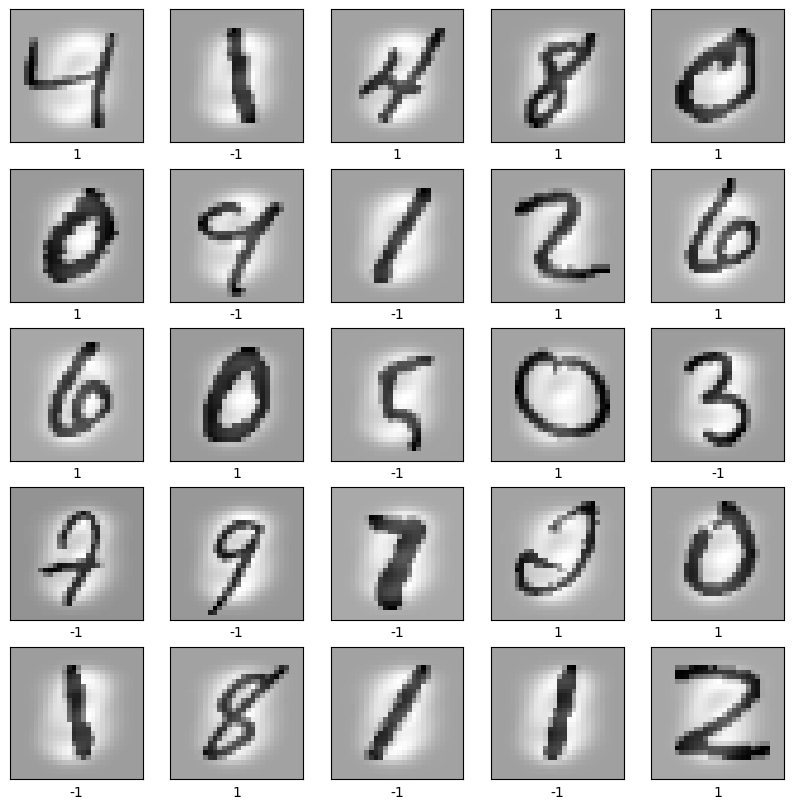

In [12]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data["test"][0][i], cmap=plt.cm.binary)
    plt.xlabel(data["test"][1][i])
plt.show()

## Model


In [13]:
reluModel = keras.Sequential(
    [
        keras.Input(shape=f_images.shape[1:]),
        keras.layers.Flatten(),
        keras.layers.Dense(2352, activation="relu", use_bias=False),
        keras.layers.Dense(2352, activation="relu", use_bias=False),
        keras.layers.Dense(1, use_bias=False),
    ]
)
linear_model = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(1, use_bias=False),
    ]
)
linear_model.compile(
    optimizer="adam",
    loss="mean_squared_error",
)

regressions = train_model(
    reluModel,
    data["train_w"],
    data["test"],
    n_epochs=120,
    batch_size=128,
    n_callbacks=50,
    callbacks={"emp": lambda model: regression_from_model(model, data, empirical=True)},
)
lin_regressions = [{"type": "Linear Regression", "emp": regression_from_model(linear_model, data, empirical=True)}]

100%|██████████| 120/120 [10:06<00:00,  5.06s/epoch, loss=0.000812, val_loss=0.072] 


## Fixed $\lambda$


In [14]:
df_real_emp = df_from_regressions(
    tqdm(choose(regressions, 5) + lin_regressions),
    {
        "emp": dict(
            lambdas=[0.1, 1, 10, 100],
            ns=np.unique(np.geomspace(10, 10_000, 200, dtype=int)),
            ns_emp=np.unique(np.geomspace(10, len(data["train_reg"][1]) / 2, 30, dtype=int)),
            repeats=5,
        )
    },
)

100%|██████████| 6/6 [03:24<00:00, 34.09s/it]


In [58]:
xstroke = dict(x="n", stroke=js("d=>`λ=${d.lamb.toFixed(1)}`"))
spec = {
    "marks": [
        Plot.line(df_real_emp.filter(pl.col("type") == "NN"), xstroke | {"y": "genErrRMT_emp", "fx": "epoch+step"}),
        Plot.ruleY(df_real_emp.filter(pl.col("type") == "NN"), {"y": "loss", "fx": "epoch+step", "stroke": js("d=>'NN loss'")}),
        Plot.dot(df_real_emp.filter(pl.col("type") == "NN"), xstroke | {"y": "genErrEmp_emp", "fx": "epoch+step"}),
        Plot.line(df_real_emp.filter(pl.col("type") == "Linear Regression"), xstroke | {"y": "genErrRMT_emp", "fx": "type"}),
        Plot.dot(df_real_emp.filter(pl.col("type") == "Linear Regression"), xstroke | {"y": "genErrEmp_emp", "fx": "type"}),
    ],
    "color": {"legend": True, "type": "categorical"},
    "width": 1200,
    "height": 700,
    "x": {"type": "log", "label": "# Samples"},
    "y": {"domain": [0.05, 1.8], "label": "Generalization error", "type": "log"},
    "grid": True,
    "fx": {"label": "Epoch"},
    "title": "Generalization error of feature ridge regression",
    "subtitle": "The circles represent the empirical generalization error, the lines the deterministic equivalent. The colors encode the size of the regularization parameter of ridge regression. The features in the first plot are untrained random features, the other plots are trained features after some number of steps of gradient descent (the facet titles have the format 'epoch'.'step'). The horizontal lines represent the loss of the neural network on the test set.",
}
obsplot(spec, path="figures/real_emp.pdf", show=False)
obsplot(spec, path="figures/real_emp.png", show=True)

In [16]:
df_real_det = df_from_regressions(
    tqdm(regressions),
    {
        "emp": dict(
            lambdas=[0.1, 1, 10],
            ns=np.geomspace(10, 10000, 200, dtype=int),
        )
    },
)

100%|██████████| 45/45 [00:04<00:00, 10.48it/s]


In [59]:
spec = {
    "marks": [
        Plot.line(
            df_real_det.sort("epoch+step", descending=True),
            dict(x="n", y="genErrRMT_emp", stroke="epoch+step", fx="lamb", opacity=0.8),
        ),
    ],
    "color": {"legend": True, "label": "Epoch", "type": "log"},
    "width": 1400,
    "height": 700,
    "x": {"type": "log", "label": "# Samples"},
    "y": {"domain": [0, 1.2], "label": "Generalization error"},
    "grid": True,
    "fx": {"label": "λ"},
    "title": "Deterministic equivalent of the generalization error",
    "subtitle": "The plot shows the dynamics of the learning curves over the training epochs for various regularization parameters.",
}
obsplot(spec, path="figures/real_det.pdf", show=False)
obsplot(spec, path="figures/real_det.png", show=True)

## Optimal $\lambda$


In [18]:
df_real_opt_emp = df_from_regressions(
    tqdm(choose(regressions, 5) + lin_regressions),
    {"emp": dict(ns=np.geomspace(30, 5000, 50, dtype=int), ns_emp=np.geomspace(30, 5000, 15, dtype=int), repeats=5)},
)

100%|██████████| 6/6 [00:36<00:00,  6.02s/it]


In [60]:
spec = {
    "marks": [
        Plot.line(df_real_opt_emp.filter(pl.col("type") == "NN"), dict(x="n", y="genErrRMT_emp", opacity=1, fx="epoch+step")),
        Plot.dot(df_real_opt_emp.filter(pl.col("type") == "NN"), dict(x="n", y="genErrEmp_emp", stroke="lamb", fx="epoch+step")),
        Plot.ruleY(df_real_opt_emp.filter(pl.col("type") == "NN"), dict(y="loss", fx="epoch+step", strokeDasharray=[5, 5])),
        Plot.line(df_real_opt_emp.filter(pl.col("type") == "Linear Regression"), dict(x="n", y="genErrRMT_emp", fx=js("d=>'Linear Regression'"))),
        Plot.dot(df_real_opt_emp.filter(pl.col("type") == "Linear Regression"), dict(x="n", y="genErrEmp_emp", stroke="lamb", fx="type")),
    ],
    "x": {"type": "log", "label": "# Samples"},
    "y": {"domain": [0.04, 0.8], "label": "Generalization error", "type": "log"},
    "grid": True,
    "fx": {"label": "λ"},
    "width": 1000,
    "height": 700,
    "color": {"legend": True, "type": "log", "label": "λ"},
    "title": "Generalization error at optimal regularisation (real data)",
    "subtitle": "The plot show the generalisation error at optimally chosen regularization parameter λ∈[1e-5, 1e5] during the NN gradient descent and for ridge regression, together with the NN generalization loss (dashed). The optimal regularization parameters have been determined from the deterministic equivalents.",
}
obsplot(spec, path="figures/real_opt_emp.pdf", show=False)
obsplot(spec, path="figures/real_opt_emp.png", show=True)

In [20]:
df_real_opt_det = df_from_regressions(
    tqdm(regressions + lin_regressions),
    {"emp": dict(ns=np.geomspace(30, 5000, 50, dtype=int))},
)

100%|██████████| 46/46 [00:59<00:00,  1.30s/it]


In [61]:
spec = {
    "marks": [
        Plot.line(df_real_opt_det.filter(pl.col("type") == "Linear Regression"), dict(x="n", y="genErrRMT_emp", opacity=1, strokeDasharray=[5, 5])),
        Plot.line(
            df_real_opt_det.filter(pl.col("type") == "NN"),
            dict(x="n", y="genErrRMT_emp", stroke="epoch+step", opacity=js("d=>d.epoch+d.step==0?1:.4")),
        ),
    ],
    "x": {"type": "log", "label": "# Samples"},
    "y": {"domain": [0.04, 1.1], "label": "Generalization error", "type": "log"},
    "grid": True,
    "fx": {"label": "λ"},
    "color": {"legend": True, "type": "log", "label": "Epoch"},
    "title": "Generalization error at optimal regularisation",
    "subtitle": "The plot show the generalisation error at optimally chosen regularization parameter λ∈[1e-5, 1e5] during the NN gradient descent (initialization emphasized) and for ridge regression (dashed).",
}
obsplot(spec, path="figures/real_opt_det.pdf", show=False)
obsplot(spec, path="figures/real_opt_det.png", show=True)

# Artificial Data


## Generate data


In [22]:
def gen_labels(x, model=None, source="model"):
    if source == "model":
        feature_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
        features = feature_model(x).numpy()
    elif source == "model_tanh":
        features = np.tanh(np.tanh(x.reshape(x.shape[0], -1) @ model.layers[1].weights[0].numpy()) @ model.layers[2].weights[0].numpy())
    elif source == "linear":
        features = x.reshape(x.shape[0], -1)
    elif source == "rf_keras":
        feature_model = keras.Sequential(
            [
                keras.Input(shape=(28, 28)),
                keras.layers.Flatten(),
                keras.layers.Dense(2352, activation="tanh", use_bias=False),
            ]
        )
        feature_model.compile(optimizer="adam", loss="mean_squared_error")
        features = feature_model(x).numpy()
    elif source == "rf":
        w = np.random.normal(0, 1, (x.shape[1] ** 2, 800)) / 800**0.5
        features = np.tanh(x.reshape(x.shape[0], -1) @ w)
    else:
        raise ValueError("Invalid Source")
    theta = np.random.normal(0, 1, features.shape[1])
    labels = np.dot(features, theta)
    labels -= labels.mean()
    labels /= labels.std()
    return labels

In [23]:
n_samples = 100_000
sample_dim = (28, 28)
flat_images = f_images.reshape(f_images.shape[0], -1)
pop_cov = flat_images.T @ flat_images / flat_images.shape[0]
pop_mean = flat_images.mean(axis=0)
images_artificial = np.random.multivariate_normal(pop_mean, pop_cov, n_samples).reshape(n_samples, *sample_dim)
labels_artificial = gen_labels(images_artificial, source="rf")

data_artificial = random_split({"test": 0.1, "train_reg": 0.1, "train_w": 0.6, "emp_cov": 0.2}, images_artificial, labels_artificial)

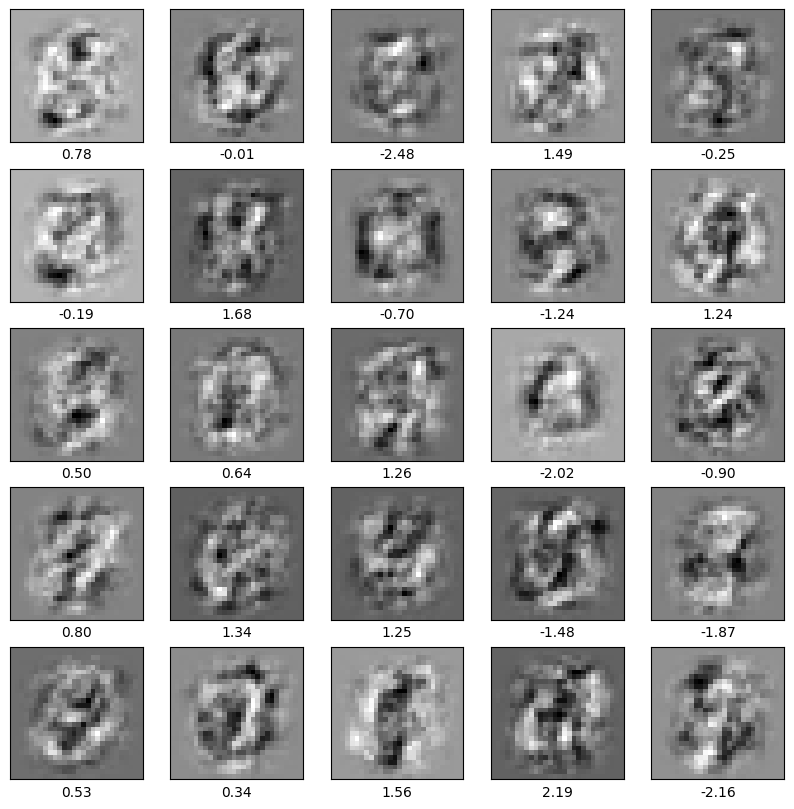

In [24]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_artificial["test"][0][i], cmap=plt.cm.binary)
    plt.xlabel(f"{data_artificial['test'][1][i]:.2f}")
plt.show()

## Model


In [34]:
tanhModel = keras.Sequential(
    [
        keras.Input(shape=f_images.shape[1:]),
        keras.layers.Flatten(),
        keras.layers.Dense(800, activation="tanh", use_bias=False),
        keras.layers.Dense(700, activation="tanh", use_bias=False),
        keras.layers.Dense(1, use_bias=False),
    ]
)

linear_model = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(1, use_bias=False),
    ]
)

linear_model.compile(
    optimizer="adam",
    loss="mean_squared_error",
)

art_regressions = train_model(
    tanhModel,
    data_artificial["train_w"],
    data_artificial["test"],
    n_epochs=15,
    batch_size=128,
    n_callbacks=20,
    callbacks={
        "emp": lambda model: regression_from_model(model, data_artificial, empirical=True),
        "lin": lambda model: regression_from_model(model, data_artificial, empirical=False),
    },
)

art_lin_regressions = [
    {
        "type": "Linear Regression",
        "emp": regression_from_model(linear_model, data_artificial, empirical=True),
        "lin": regression_from_model(linear_model, data_artificial, empirical=False),
    }
]

100%|██████████| 15/15 [01:35<00:00,  6.35s/epoch, loss=0.0123, val_loss=0.0381]


## Fixed $\lambda$


In [35]:
df_art_emp = df_from_regressions(
    tqdm(choose(art_regressions, 5) + art_lin_regressions),
    {
        "emp": dict(
            lambdas=[0.1, 1, 10, 100],
            ns=np.unique(np.geomspace(10, 10_000, 200, dtype=int)),
            ns_emp=np.unique(np.geomspace(10, len(data_artificial["train_reg"][1]) / 2, 30, dtype=int)),
            repeats=5,
        ),
        "lin": dict(
            lambdas=[0.1, 1, 10, 100],
            ns=np.unique(np.geomspace(10, 10_000, 200, dtype=int)),
        ),
    },
)

100%|██████████| 6/6 [00:57<00:00,  9.59s/it]


In [62]:
xstroke = dict(x="n", stroke=js("d=>`λ=${d.lamb.toFixed(1)}`"))
spec = {
    "marks": [
        Plot.line(df_art_emp.filter(pl.col("type") == "NN"), xstroke | {"y": "genErrRMT_emp", "fx": "epoch+step"}),
        Plot.line(df_art_emp.filter(pl.col("type") == "NN"), xstroke | {"y": "genErrRMT_lin", "fx": "epoch+step", "strokeDasharray": [5, 5]}),
        Plot.ruleY(df_art_emp.filter(pl.col("type") == "NN"), {"y": "loss", "fx": "epoch+step", "stroke": js("d=>'NN loss'")}),
        Plot.dot(df_art_emp.filter(pl.col("type") == "NN"), xstroke | {"y": "genErrEmp_emp", "fx": "epoch+step"}),
        Plot.line(df_art_emp.filter(pl.col("type") == "Linear Regression"), xstroke | {"y": "genErrRMT_emp", "fx": "type"}),
        Plot.dot(df_art_emp.filter(pl.col("type") == "Linear Regression"), xstroke | {"y": "genErrEmp_emp", "fx": "type"}),
    ],
    "color": {"legend": True, "type": "categorical"},
    "width": 1200,
    "height": 700,
    "x": {"type": "log", "label": "# Samples"},
    "y": {"domain": [0.02, 0.7], "label": "Generalization error", "type": "log"},
    "grid": True,
    "fx": {"label": "Epoch"},
    "title": "Generalization error of feature ridge regression",
    "subtitle": "The circles represent the empirical generalization error, the lines the deterministic equivalent. The colors encode the size of the regularization parameter of ridge regression. The features in the first plot are untrained random features, the other plots are trained features after some number of steps of gradient descent (the facet titles have the format 'epoch'.'step'). The horizontal lines represent the loss of the neural network on the test set.",
}
obsplot(spec, path="figures/art_emp.pdf", show=False)
obsplot(spec, path="figures/art_emp.png", show=True)

In [39]:
df_art_det = df_from_regressions(
    tqdm(art_regressions),
    {
        "emp": dict(
            lambdas=[0.1, 1, 10],
            ns=np.geomspace(10, 10000, 200, dtype=int),
        )
    },
)

100%|██████████| 19/19 [00:01<00:00, 11.83it/s]


In [63]:
spec = {
    "marks": [
        Plot.line(
            df_art_det.sort("epoch+step", descending=True),
            dict(x="n", y="genErrRMT_emp", stroke="epoch+step", fx="lamb", opacity=0.8),
        ),
    ],
    "color": {"legend": True, "label": "Epoch", "type": "log"},
    "width": 800,
    "height": 500,
    "x": {"type": "log", "label": "# Samples"},
    "y": {"domain": [0.02, 0.8], "label": "Generalization error", "type": "log"},
    "grid": True,
    "fx": {"label": "λ"},
    "title": "Deterministic equivalent of the generalization error",
    "subtitle": "The plot shows the dynamics of the learning curves over the training epochs for various regularization parameters.",
}
obsplot(spec, path="figures/art_det.pdf", show=False)
obsplot(spec, path="figures/art_det.png", show=True)

## Optimal $\lambda$


In [47]:
df_art_opt_emp = df_from_regressions(
    tqdm(choose(art_regressions, 5) + art_lin_regressions),
    {"emp": dict(ns=np.geomspace(30, 5000, 50, dtype=int), ns_emp=np.geomspace(30, 5000, 15, dtype=int), repeats=5)},
)

100%|██████████| 6/6 [00:21<00:00,  3.57s/it]


In [64]:
spec = {
    "marks": [
        Plot.line(df_art_opt_emp.filter(pl.col("type") == "NN"), dict(x="n", y="genErrRMT_emp", opacity=1, fx="epoch+step")),
        Plot.dot(df_art_opt_emp.filter(pl.col("type") == "NN"), dict(x="n", y="genErrEmp_emp", stroke="lamb", fx="epoch+step")),
        Plot.ruleY(df_art_opt_emp.filter(pl.col("type") == "NN"), dict(y="loss", fx="epoch+step", strokeDasharray=[5, 5])),
        Plot.line(df_art_opt_emp.filter(pl.col("type") == "Linear Regression"), dict(x="n", y="genErrRMT_emp", fx=js("d=>'Linear Regression'"))),
        Plot.dot(df_art_opt_emp.filter(pl.col("type") == "Linear Regression"), dict(x="n", y="genErrEmp_emp", stroke="lamb", fx="type")),
    ],
    "x": {"type": "log", "label": "# Samples"},
    "y": {"domain": [0.02, 0.8], "label": "Generalization error", "type": "log"},
    "grid": True,
    "fx": {"label": "λ"},
    "width": 1000,
    "height": 700,
    "color": {"legend": True, "type": "log", "label": "λ"},
    "title": "Generalization error at optimal regularisation (real data)",
    "subtitle": "The plot show the generalisation error at optimally chosen regularization parameter λ∈[1e-5, 1e5] during the NN gradient descent and for ridge regression, together with the NN generalization loss (dashed). The optimal regularization parameters have been determined from the deterministic equivalents.",
}
obsplot(spec, path="figures/art_opt_emp.pdf", show=False)
obsplot(spec, path="figures/art_opt_emp.png", show=True)

In [52]:
df_art_opt_det = df_from_regressions(
    tqdm(art_regressions + art_lin_regressions),
    {"emp": dict(ns=np.geomspace(30, 5000, 50, dtype=int))},
)

100%|██████████| 20/20 [00:00<00:00, 23.55it/s]


In [65]:
spec = {
    "marks": [
        Plot.line(df_art_opt_det.filter(pl.col("type") == "Linear Regression"), dict(x="n", y="genErrRMT_emp", opacity=1, strokeDasharray=[5, 5])),
        Plot.line(
            df_art_opt_det.filter(pl.col("type") == "NN"),
            dict(x="n", y="genErrRMT_emp", stroke="epoch+step", opacity=js("d=>d.epoch+d.step==0?1:.4")),
        ),
    ],
    "x": {"type": "log", "label": "# Samples"},
    "y": {"label": "Generalization error", "type": "log"},
    "grid": True,
    "fx": {"label": "λ"},
    "color": {"legend": True, "type": "log", "label": "Epoch"},
    "title": "Generalization error at optimal regularisation",
    "subtitle": "The plot show the generalisation error at optimally chosen regularization parameter λ∈[1e-5, 1e5] during the NN gradient descent (initialization emphasized) and for ridge regression (dashed).",
}
obsplot(spec, path="figures/art_opt_det.pdf", show=False)
obsplot(spec, path="figures/art_opt_det.png", show=True)